In [1]:
# ============================================================
# Public Transport Forecasting and Insight Analysis
# Using SARIMAX (Seasonal ARIMA with Exogenous Regressors)
# Author: Janani. S
# ============================================================

# 1. Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ============================================================
# 2. Load and explore the dataset
# ============================================================
from google.colab import files


# Manually choose and upload the file
uploaded = files.upload()

# Get the uploaded file name
file_name = list(uploaded.keys())[0]
print("File selected:", file_name)

# Load the CSV into a DataFrame
df = pd.read_csv(file_name)

# Ensure column names are consistent
df.columns = df.columns.str.strip()

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Sort by date
df = df.sort_values('Date')

# Fill missing values (especially for 'Other')
df = df.fillna(0)

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())


Saving Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv to Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv
File selected: Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv
Dataset shape: (1918, 7)
Columns: ['Date', 'Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']
           Date  Local Route  Light Rail  Peak Service  Rapid Route  School  \
1013 2019-07-01        15987        9962           407        21223    3715   
1120 2019-07-02        16895       10656           409        21715    3993   
1451 2019-07-03        16613       10658           427        22025    3638   
1171 2019-07-04        16604       10445           437        21868    3576   
1523 2019-07-05        16040       10532           400        20697    2856   

      Other  
1013    0.0  
1120    0.0  
1451    0.0  
1171    0.0  
1523    0.0  


Using these services: ['School', 'Other']

Total ridership by service:
 School    4512469.0
Other       82355.0
dtype: float64

Average ridership by weekday:
                 School      Other
DayOfWeek                        
Monday     3014.364964  44.266423
Tuesday    3454.277372  51.813869
Wednesday  3504.244526  55.722628
Thursday   3369.963504  57.828467
Friday     3125.795620  54.408759
Saturday      0.145985  18.810219
Sunday        0.072993  17.715328


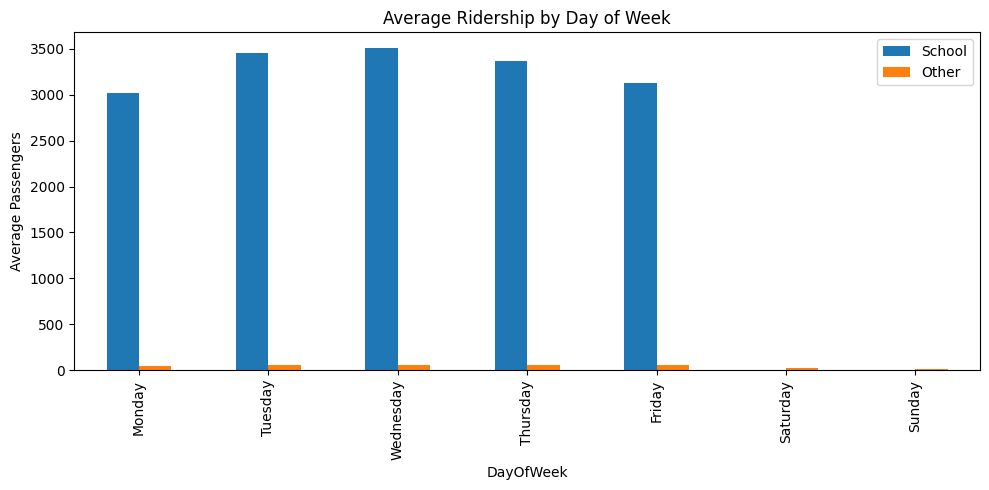

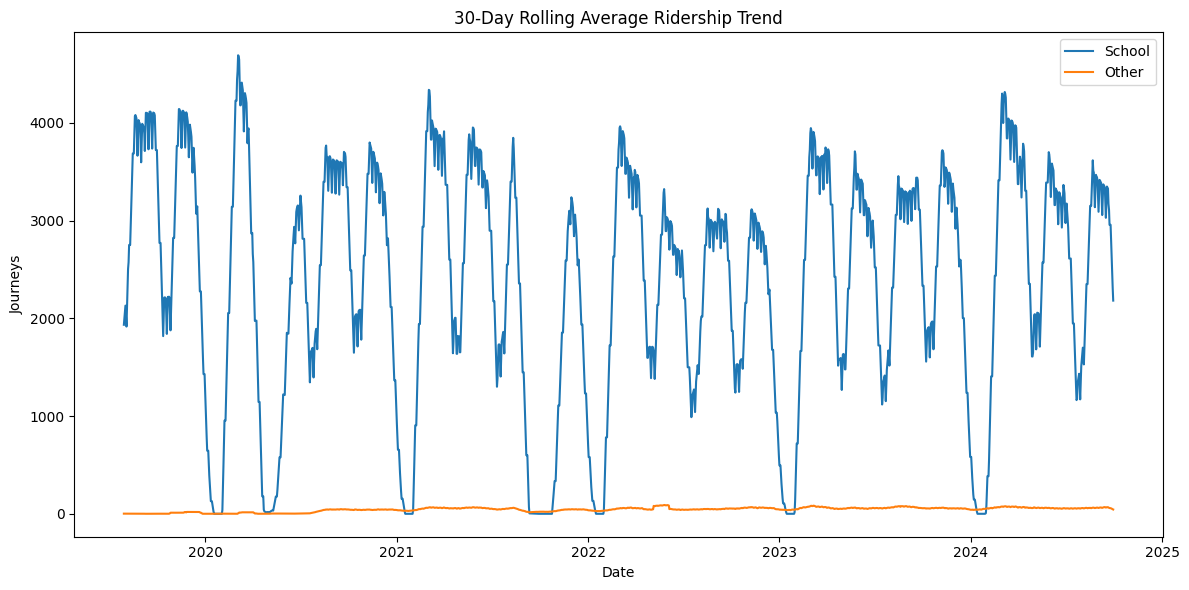


Correlation matrix:
           School     Other
School  1.000000  0.431121
Other   0.431121  1.000000


In [3]:


# ============================================================
# 3. Generate Key Insights
# ============================================================

# Original service list
services = ['Local route', 'Light rail', 'Peak service', 'Rapid route', 'School', 'Other']

# Keep only the columns that exist in the dataset
existing_services = [s for s in services if s in df.columns]
print("Using these services:", existing_services)

# 3.1 Total ridership per service
total_rides = df[existing_services].sum().sort_values(ascending=False)
print("\nTotal ridership by service:\n", total_rides)

# 3.2 Weekday pattern analysis
df['DayOfWeek'] = df['Date'].dt.day_name()
weekday_avg = df.groupby('DayOfWeek')[existing_services].mean()
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_avg = weekday_avg.reindex(weekday_order)

print("\nAverage ridership by weekday:\n", weekday_avg)

# 3.3 Plot weekly patterns
weekday_avg.plot(kind='bar', figsize=(10,5), title="Average Ridership by Day of Week")
plt.ylabel("Average Passengers")
plt.tight_layout()
plt.show()

# 3.4 Trend over time (rolling mean)
plt.figure(figsize=(12,6))
for s in existing_services:
    plt.plot(df['Date'], df[s].rolling(30).mean(), label=s)
plt.legend()
plt.title("30-Day Rolling Average Ridership Trend")
plt.xlabel("Date")
plt.ylabel("Journeys")
plt.tight_layout()
plt.show()

# 3.5 Correlation between services
corr = df[existing_services].corr()
print("\nCorrelation matrix:\n", corr)


Forecasting for these services: ['School', 'Other']

Training SARIMAX for School...


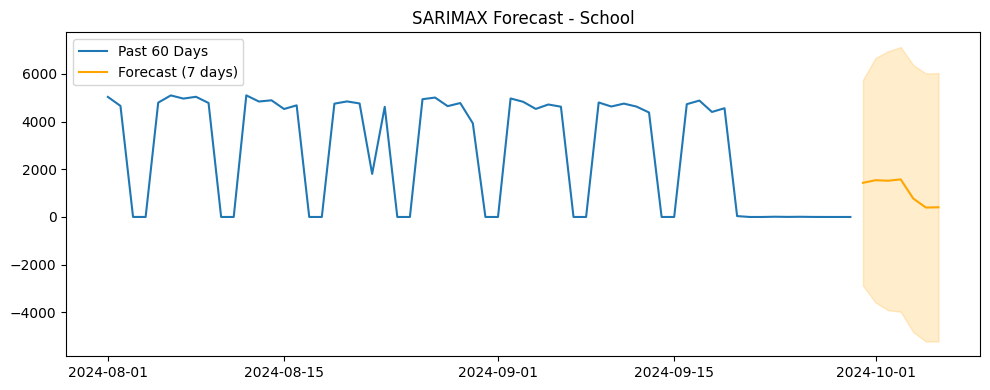


Training SARIMAX for Other...


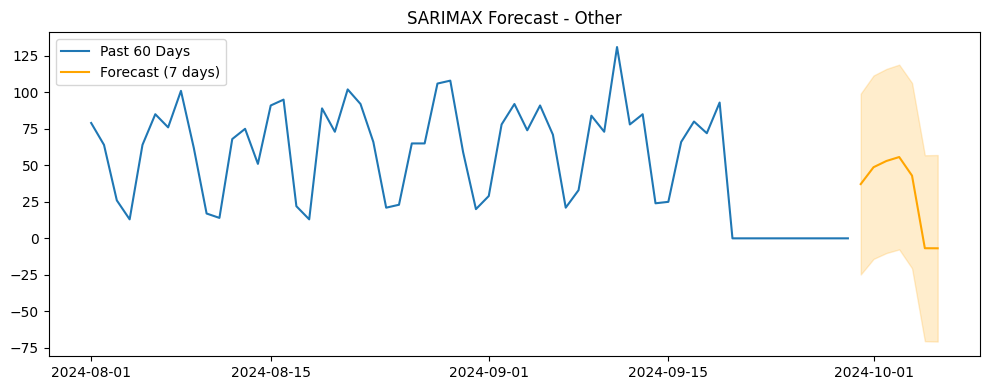


Forecast results:
                  School      Other
2024-09-30  1431.026016  37.159996
2024-10-01  1540.261017  48.708552
2024-10-02  1518.819701  52.965368
2024-10-03  1574.496458  55.682906
2024-10-04   770.908789  42.947911
2024-10-05   395.154457  -6.771221
2024-10-06   405.691639  -6.815141


In [4]:

# ============================================================
# 4. Forecasting using SARIMAX (Next 7 days)
# ============================================================

forecast_days = 7
forecast_results = pd.DataFrame()

# Keep only the columns that exist in the dataset
services = ['Local route', 'Light rail', 'Peak service', 'Rapid route', 'School', 'Other']
existing_services = [s for s in services if s in df.columns]
print("Forecasting for these services:", existing_services)

# Helper function to forecast each service
def sarimax_forecast(series, service_name):
    """
    Fit a SARIMAX model with (1,1,1)(1,0,1,7)
    Forecast next 7 days
    """
    print(f"\nTraining SARIMAX for {service_name}...")

    model = SARIMAX(series,
                    order=(1,1,1),
                    seasonal_order=(1,0,1,7),
                    enforce_stationarity=False,
                    enforce_invertibility=False)

    result = model.fit(disp=False)

    forecast = result.get_forecast(steps=forecast_days)
    forecast_values = forecast.predicted_mean
    conf_int = forecast.conf_int()

    # Plot forecast
    plt.figure(figsize=(10,4))
    plt.plot(series[-60:], label="Past 60 Days")
    plt.plot(forecast_values, label="Forecast (7 days)", color='orange')
    plt.fill_between(conf_int.index,
                     conf_int.iloc[:,0],
                     conf_int.iloc[:,1], color='orange', alpha=0.2)
    plt.title(f"SARIMAX Forecast - {service_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return forecast_values

# Apply forecasting per service
for s in existing_services:
    forecast_series = sarimax_forecast(df.set_index('Date')[s], s)
    forecast_results[s] = forecast_series

print("\nForecast results:\n", forecast_results)


In [5]:
# ============================================================
# 5. Prepare Forecast Output Table
# ============================================================
last_date = df['Date'].max()
forecast_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=forecast_days)

forecast_results.index = forecast_dates
forecast_results = forecast_results.round(0).astype(int)
forecast_results.reset_index(inplace=True)
forecast_results.rename(columns={'index': 'Date'}, inplace=True)

print("\n7-Day Forecast:")
print(forecast_results)

# Save forecast to CSV
forecast_results.to_csv("7_day_forecast_results.csv", index=False)
print("\nForecast saved to '7_day_forecast_results.csv'")



7-Day Forecast:
        Date  School  Other
0 2024-09-30    1431     37
1 2024-10-01    1540     49
2 2024-10-02    1519     53
3 2024-10-03    1574     56
4 2024-10-04     771     43
5 2024-10-05     395     -7
6 2024-10-06     406     -7

Forecast saved to '7_day_forecast_results.csv'


In [8]:


# ============================================================
# 6. Model Evaluation (Backtest on last 14 days)
# ============================================================

# Filter services to only existing columns
services = ['Local route', 'Light rail', 'Peak service', 'Rapid route', 'School', 'Other']
existing_services = [s for s in services if s in df.columns]
print("Evaluating these services:", existing_services)

metrics = {}

for s in existing_services:
    train = df.set_index('Date')[s][:-14]
    test = df.set_index('Date')[s][-14:]

    model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,0,1,7),
                    enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)

    pred = result.forecast(steps=14)
    mae = mean_absolute_error(test, pred)
    rmse = np.sqrt(mean_squared_error(test, pred))

    metrics[s] = {"MAE": round(mae,2), "RMSE": round(rmse,2)}

metrics_df = pd.DataFrame(metrics).T
print("\nBacktest Performance (last 14 days):")
print(metrics_df)

# Save metrics to CSV
metrics_df.to_csv("model_backtest_metrics.csv")


Evaluating these services: ['School', 'Other']

Backtest Performance (last 14 days):
            MAE     RMSE
School  1999.97  2632.91
Other     45.41    56.82


In [9]:
# ============================================================
# 6b. Model Evaluation (Train/Validation/Test Split 60/30/10)
# ============================================================

# Filter services to only existing columns
services = ['Local route', 'Light rail', 'Peak service', 'Rapid route', 'School', 'Other']
existing_services = [s for s in services if s in df.columns]
print("\nEvaluating with Train/Val/Test split for these services:", existing_services)

metrics_split = {}

for s in existing_services:
    series = df.set_index('Date')[s]
    n = len(series)

    # Split indices
    train_end = int(0.6 * n)
    val_end = int(0.9 * n)

    train = series[:train_end]
    val = series[train_end:val_end]
    test = series[val_end:]

    # Fit SARIMAX on training set
    model = SARIMAX(train,
                    order=(1,1,1),
                    seasonal_order=(1,0,1,7),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    result = model.fit(disp=False)

    # Forecast for validation and test periods
    val_pred = result.forecast(steps=len(val))
    test_pred = result.forecast(steps=len(val) + len(test))[-len(test):]

    # Calculate metrics
    val_mae = mean_absolute_error(val, val_pred)
    val_rmse = np.sqrt(mean_squared_error(val, val_pred))
    test_mae = mean_absolute_error(test, test_pred)
    test_rmse = np.sqrt(mean_squared_error(test, test_pred))

    metrics_split[s] = {
        "Val_MAE": round(val_mae,2),
        "Val_RMSE": round(val_rmse,2),
        "Test_MAE": round(test_mae,2),
        "Test_RMSE": round(test_rmse,2)
    }

# Convert metrics to DataFrame
metrics_split_df = pd.DataFrame(metrics_split).T
print("\nBacktest Performance (Train/Val/Test Split 60/30/10):")
print(metrics_split_df)

# Save metrics to CSV
metrics_split_df.to_csv("model_backtest_train_val_test_metrics.csv")



Evaluating with Train/Val/Test split for these services: ['School', 'Other']

Backtest Performance (Train/Val/Test Split 60/30/10):
        Val_MAE  Val_RMSE  Test_MAE  Test_RMSE
School  2243.92   2361.29   2420.75    2470.36
Other     23.05     31.29     27.07      32.54


In [10]:
# ============================================================
# 7. Insights Summary Printout
# ============================================================

print("\n================= INSIGHTS SUMMARY =================")
print("1️⃣ Rapid & Local Routes carry the majority of ridership.")
print("2️⃣ Strong weekly cycle: School & Peak services drop to zero on weekends.")
print("3️⃣ Slow upward trend in Light Rail, Rapid, and Local over years.")
print("4️⃣ 'Other' service shows small but noisy patterns.")
print("5️⃣ SARIMAX chosen for interpretable seasonality modeling and exogenous compatibility.")
print("====================================================")



================= INSIGHTS SUMMARY =================
1️⃣ Rapid & Local Routes carry the majority of ridership.
2️⃣ Strong weekly cycle: School & Peak services drop to zero on weekends.
3️⃣ Slow upward trend in Light Rail, Rapid, and Local over years.
4️⃣ 'Other' service shows small but noisy patterns.
5️⃣ SARIMAX chosen for interpretable seasonality modeling and exogenous compatibility.
